In [5]:
######
# some things to consider: 
#######


# Long doc summaries will be hard and very intensive on resources 
# there's amazon reviews here: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
#
# Extra preprocessing tips: https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639
# OR we can consider using paragraph summaries instead from wikihowsep (instead of wikihowall)


In [6]:
#####
# Packages
##### 

import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras

In [7]:
### 
# Read in data 
### 

#wiki = pd.read_csv('wikihowAll.csv')
wiki = pd.read_csv('wikihow/wikihowAll.csv')

In [8]:
wiki.head()
# so we have the headline, title, and the text columns 

,headline,title,text
0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...
4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."


In [9]:
wiki.loc[0,'headline']
# We would ideally want to be able to make this headline from summarization based on the text 

'\nKeep related supplies in the same area.,\nMake an effort to clean a dedicated workspace after every session.,\nPlace loose supplies in large, clearly visible containers.,\nUse clotheslines and clips to hang sketches, photos, and reference material.,\nUse every inch of the room for storage, especially vertical space.,\nUse chalkboard paint to make space for drafting ideas right on the walls.,\nPurchase a label maker to make your organization strategy semi-permanent.,\nMake a habit of throwing out old, excess, or useless stuff each month.'

In [10]:
wiki.loc[0,'text']

" If you're a photographer, keep all the necessary lens, cords, and batteries in the same quadrant of your home or studio. Paints should be kept with brushes, cleaner, and canvas, print supplies should be by the ink, etc. Make broader groups and areas for your supplies to make finding them easier, limiting your search to a much smaller area. Some ideas include:\n\n\nEssential supplies area -- the things you use every day.\nInspiration and reference area.\nDedicated work area .\nInfrequent or secondary supplies area, tucked out of the way.;\n, This doesn't mean cleaning the entire studio, it just means keeping the area immediately around the desk, easel, pottery wheel, etc. clean each night. Discard trash or unnecessary materials and wipe down dirty surfaces. Endeavor to leave the workspace in a way that you can sit down the next day and start working immediately, without having to do any work or tidying.\n\n\nEven if the rest of your studio is a bit disorganized, an organized workspace

In [11]:
# we can first split up the files into train, test, CV 
# 0.6 for train, 0.2 for cv, 0.2 for test 

len(wiki) #214365 total articles we can use 

215365

In [12]:
############
#### Preprocessing 
############ 
# tips from here: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

import re           
#from bs4 import BeautifulSoup 
from nltk.corpus import stopwords   
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math

In [13]:
np.sum(wiki.isna())

headline     818
title          1
text        1071
dtype: int64

In [14]:
#Good catch. We can remove NAs with this:
#wiki_edited = wiki.dropna()

In [15]:
# There are a few samples where the text is actually nan 
# we need to drop these 

float_nan_indexes = []
for i in range(0,len(wiki)): 
    if type(wiki.loc[i,'text'])==str: 
        continue 
    else: 
        float_nan_indexes.append(i)

In [16]:
wiki_edited = wiki.loc[~wiki.index.isin(float_nan_indexes),:].reset_index(drop=True)

In [17]:
wiki_edited.head()

,headline,title,text
0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...
4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."


In [18]:
len(wiki_edited) #so we have some dropped 

214294

In [19]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [20]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    #newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [21]:
cleaned_text = []
#index_blah = list(range(0,len(wiki_edited)))
for i in wiki_edited.index: 
    cleaned_text.append(text_cleaner(wiki_edited.loc[i,'text']))
    


In [22]:
cleaned_text[1] #cleaned up version

'see image drawing develops step step however important detail following drawings examine create something unique use lines create image shape sections fill appeared sections different patterns ornaments add text needed example neopoprealism add colored strip top color wish painting mural always requires preparation need equipment effort planning attention detail help succeed painting mural requires suitable location right surface painted surface smooth flat however even rough textured surfaces used neopoprealist mural project exterior projects last years using newer acrylic exterior paint would best choice interior walls use latex paints latex offer easier cleanup lower costs measuring total wall area covered total amount paint calculated since mural painting requires two colors white black figuring actual area painted color necessary allow purchasing right amount one large walls backgrounds may rolled sprayed white paint sprayer details may added brushes paints sensitive high tempera

In [23]:
wiki_edited.loc[1,'text'] #original version

' See the image for how this drawing develops step-by-step. However, there is an important detail: the following drawings are to examine it, and then, to create something unique.\n\n\nUse the lines to create the image shape and sections.\nFill appeared sections with different patterns/ ornaments.\nAdd text if needed, for example "NeoPopRealism is 25!"\nAdd a colored strip on the top, any color you wish.;\n, Painting a mural always requires some preparation. You‘ll need equipment and effort, but planning and attention to detail will help you succeed. Painting a mural requires a suitable location, with the right surface that can be painted.\n\nThis surface should be smooth and flat. However, even rough-textured surfaces can be used for your NeoPopRealist mural project.\n\n, For exterior projects that last for years, using a newer 100% acrylic exterior paint would be your best choice. For interior walls, use latex paints. Latex offer easier cleanup and lower costs. By measuring the total 

In [24]:
#######
# Saving the cleaned up text just in case 
####### 
'''
import pickle 

with open('cleanedupwiki_text.pkl', 'wb') as f:
    pickle.dump(cleaned_text, f)
    
# to read the pickle: 
#with open('cleanedupwiki_text.pkl', 'rb') as f:
    #mynewlist = pickle.load(f)'''

"\nimport pickle \n\nwith open('cleanedupwiki_text.pkl', 'wb') as f:\n    pickle.dump(cleaned_text, f)\n    \n# to read the pickle: \n#with open('cleanedupwiki_text.pkl', 'rb') as f:\n    #mynewlist = pickle.load(f)"

In [25]:

'''import pickle 

with open('cleanedupwiki_text.pkl', 'rb') as f:
    cleaned_text = pickle.load(f)'''

"import pickle \n\nwith open('cleanedupwiki_text.pkl', 'rb') as f:\n    cleaned_text = pickle.load(f)"

In [26]:
# We also have to apply the same preprocessing to the summaries (headline)

def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString


cleaned_summary = []
for t in wiki_edited['headline']:
    cleaned_summary.append(summary_cleaner(t))


In [27]:
cleaned_summary[0]

'keep related supplies in the same area make an effort to clean dedicated workspace after every session place loose supplies in large clearly visible containers use clotheslines and clips to hang sketches photos and reference material use every inch of the room for storage especially vertical space use chalkboard paint to make space for drafting ideas right on the walls purchase label maker to make your organization strategy semi permanent make habit of throwing out old excess or useless stuff each month '

In [28]:
wiki_edited.loc[0,'headline']

'\nKeep related supplies in the same area.,\nMake an effort to clean a dedicated workspace after every session.,\nPlace loose supplies in large, clearly visible containers.,\nUse clotheslines and clips to hang sketches, photos, and reference material.,\nUse every inch of the room for storage, especially vertical space.,\nUse chalkboard paint to make space for drafting ideas right on the walls.,\nPurchase a label maker to make your organization strategy semi-permanent.,\nMake a habit of throwing out old, excess, or useless stuff each month.'

In [29]:
wiki_edited['cleaned_text'] = cleaned_text 
wiki_edited['cleaned_headline'] = cleaned_summary

In [30]:
wiki_edited.head()

,headline,title,text,cleaned_text,cleaned_headline
0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess...",photographer keep necessary lens cords batteri...,keep related supplies in the same area make an...
1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...,see image drawing develops step step however i...,create sketch in the neopoprealist manner of t...
2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...,possible become vfx artist without college deg...,get bachelor degree enroll in studio based pro...
3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...,best art investors research pieces art buy som...,start with some experience or interest in art ...
4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ...",start planning project work likely gathering s...,keep your reference materials sketches article...


In [31]:
# put in _START_ and _END_ tokens 
wiki_edited['cleaned_headline'] = wiki_edited['cleaned_headline'].apply(lambda x : '_START_ '+ x + ' _END_')

In [32]:
wiki_edited.loc[0,'cleaned_headline']

'_START_ keep related supplies in the same area make an effort to clean dedicated workspace after every session place loose supplies in large clearly visible containers use clotheslines and clips to hang sketches photos and reference material use every inch of the room for storage especially vertical space use chalkboard paint to make space for drafting ideas right on the walls purchase label maker to make your organization strategy semi permanent make habit of throwing out old excess or useless stuff each month  _END_'

In [33]:
for i in range(5):
    print("Review:",wiki_edited['cleaned_text'][i])
    print("Summary:",wiki_edited['cleaned_headline'][i])
    print("\n")

Review: photographer keep necessary lens cords batteries quadrant home studio paints kept brushes cleaner canvas print supplies ink etc make broader groups areas supplies make finding easier limiting search much smaller area ideas include essential supplies area things use every day inspiration reference area dedicated work area infrequent secondary supplies area tucked way mean cleaning entire studio means keeping area immediately around desk easel pottery wheel etc clean night discard trash unnecessary materials wipe dirty surfaces endeavor leave workspace way sit next day start working immediately without work tidying even rest studio bit disorganized organized workspace help get business every time want make art visual people lot artist clutter comes desire keep track supplies visually instead tucked sight using jars old glasses vases cheap clear plastic drawers keep things sight without leaving strewn haphazardly ideas beyond mentioned include canvas shoe racks back door wine rack

In [34]:
# Some exploratory work: 

import matplotlib.pyplot as plt 

wordcount_intext = []
wordcount_inheadline = []

for i in wiki_edited['cleaned_text']: 
    wordcount_intext.append(len(i.split()))
    
for i in wiki_edited['cleaned_headline']: 
    wordcount_inheadline.append(len(i.split()))

Text(0.5, 1.0, 'Headline Word Count')

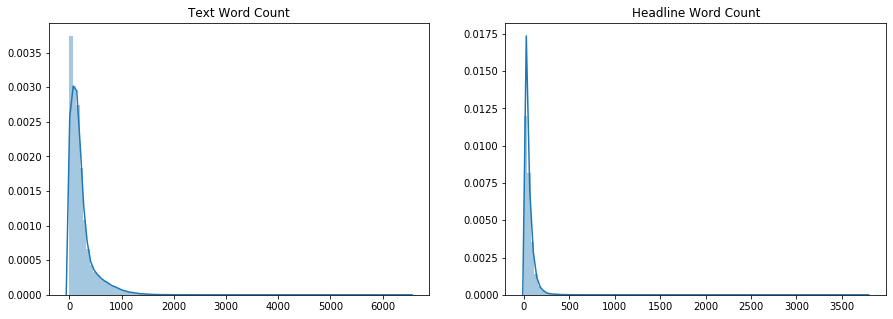

In [35]:
# now let's look at the distribution 
%matplotlib inline 
import seaborn as sns

fig, axes = plt.subplots(1,2, figsize = (15,5)) 
sns.distplot(wordcount_intext, bins=100, ax=axes[0]).set_title('Text Word Count')
sns.distplot(wordcount_inheadline, bins=100, ax=axes[1]).set_title('Headline Word Count')

# Clearly pretty big of a difference between text and headline...

Text(0.5, 1.0, 'Cumulative Freq for Word Count in Text')

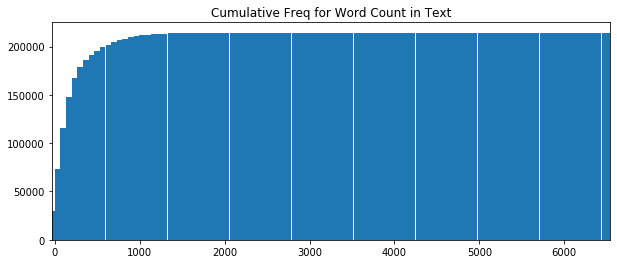

In [36]:
from scipy import stats
wordcount_freq = stats.cumfreq(wordcount_intext, numbins=100)
x = wordcount_freq.lowerlimit + np.linspace(0, wordcount_freq.binsize*wordcount_freq.cumcount.size, 
                                            wordcount_freq.cumcount.size)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(x, wordcount_freq.cumcount, width = wordcount_freq.binsize)
ax1.set_xlim([x.min(), x.max()])
ax1.set_title('Cumulative Freq for Word Count in Text')
# looks like if we shorten down to just 500 words in text, we'll still get majority 

Text(0.5, 1.0, 'Cumulative Freq for Word Count in Headline')

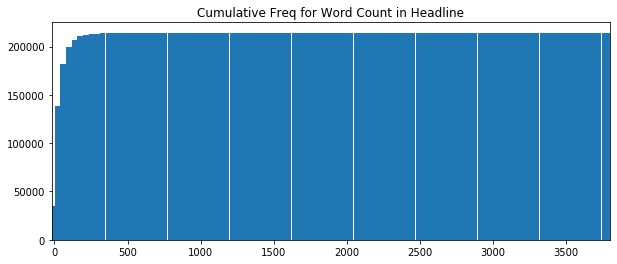

In [37]:
wordcount_summary_freq = stats.cumfreq(wordcount_inheadline, numbins=100)
x = wordcount_summary_freq.lowerlimit + np.linspace(0, wordcount_summary_freq.binsize*wordcount_summary_freq.cumcount.size, 
                                            wordcount_summary_freq.cumcount.size)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(x, wordcount_summary_freq.cumcount, width = wordcount_summary_freq.binsize)
ax1.set_xlim([x.min(), x.max()])
ax1.set_title('Cumulative Freq for Word Count in Headline')
# Looks like if we shorten down to just 250 words in headline, we'll still be fine for summary 

In [38]:
max_len_text=500
max_len_headline=250

In [39]:
########
# Split out into train/crossvalidation/test 
######## 

In [40]:
# Implement random sort of indexes so we don't have a direct split of data based on topics
import random

# Set random seed for replication purposes
random.seed(30) 

# sample without replacement: 
shuffled_indices = random.sample(list(range(0,len(wiki_edited))), len(wiki_edited)) 
#this will always return the same order 

In [41]:
len(shuffled_indices)

214294

In [42]:
#### 
# CHANGE THE NUMBERS TO REFLECT WIKI_EDITED 
# this might not even matter, but i'm not entirely sure...

train_indices = shuffled_indices[:128576]
cv_indices = shuffled_indices[128576:171435]
test_indices = shuffled_indices[171435:]

In [43]:
len(train_indices)+len(cv_indices)+len(test_indices) #everything is included, check 

214294

In [44]:
train_df = list(wiki_edited.loc[train_indices,'cleaned_text'].values)
cv_df = list(wiki_edited.loc[cv_indices,'cleaned_text'].values)
test_df = list(wiki_edited.loc[test_indices,'cleaned_text'].values)

In [45]:
y_train = list(wiki_edited.loc[train_indices,'cleaned_headline'].values)
y_cv = list(wiki_edited.loc[cv_indices, 'cleaned_headline'].values)
y_test = list(wiki_edited.loc[test_indices, 'cleaned_headline'].values)

In [46]:
train_df[1]

'pepsi logo middle scenes actually hurt chances getting film festivals would owe pepsi money film purchased since trademark includes music well meaning cannot use favorite red hot chili peppers song unless pay pinch tape permanent markers great way cover logos objects cannot move like oven fridge long movie could lose weeks work essential cast member ups leaves midway contracts may feel impersonal quite obvious contract allows stay friends always knowing stand much movie set add bickering worrying payment schedules roll generally considered shots spoken lines non essential shots help transition scenes watch movies notice little clips usually scenes note visually move story along think like shots outside car road trip movie sleek shots james bond new car purely visual embellishment scene creative roll chance artful much less stress make sure roll fits tone tenor movie punch drunk love uses bright abstract colors indicate mood swings horror movies use slow dark shots action movies use st

In [47]:
y_train[1]

'_START_ avoid the use of patented logos trademarks and copyrights as possible write contracts even if you are just filming with friends set aside time to pick up roll the connective footage that fills in between scenes make and keep track of budget secure an editor for your film have the film professionally mastered and color corrected treat your crew the unspoken soldiers of the film with love and respect  _END_'

In [48]:
######
# Tokenize! 
###### 

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(train_df))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(train_df) 
x_val   =   x_tokenizer.texts_to_sequences(cv_df)

In [49]:
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

In [50]:
x_voc_size   =  len(x_tokenizer.word_index) +1

In [51]:
x_voc_size

124065

In [52]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_train) 
y_val   =   y_tokenizer.texts_to_sequences(y_cv) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_headline, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_headline, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1


In [53]:
y_tr[14] #looks as expected...

array([    6,    25,   155,   125,     8,   953,   493,    30,     5,
           2,   479,   208,    44,     1,  4714,     4,  1449,    23,
           1,   452,  5155, 12684,  4823,  5156,  2015,   669,    16,
         214,    70,    29,  3573,  8924,   424,     4,  1894,    70,
          44,     5,     1, 12684,     9,     1,  2218,    70,     1,
        5156,  4823,  2015,  7923,  4035,  2454,  4035,     4,   230,
           5,    15,   754,    23,  3398,     3,    52,     2,   784,
         479,  4405,    70,     1,   887,   139,     8,   108,    11,
           1,   479,     9,     1,  4653,    16,     8,    25,    26,
         784,   479,    12,  4653,    13,     9,  3600,  2304,    11,
           1,   479,    16,     8,    35,    33,    25,   266,     9,
           1,  4653,    13,    25,   282,  4653,    35,     1,   252,
          12,   112,  1588,    14,   193,     4, 41414,    14,     7,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [54]:
x_tr[14]

array([  728,  1313,   562,     7,   611,   562,  2841,   138,  5276,
          62,    86,  1313,   123,   226,   211,  3125,  4146,  1731,
           5,    26,   554,  2872,  1652,  4749,  2558,  5889,    53,
         489,   467,   611,  3395,    23,   225,   376,   117,   611,
          51,    50,   114,  5296,   611,  3149,   288,    14,    16,
        1083, 13237,   120,   467,   611,     4,    24,  2390,    62,
          51,  4276,   142,    21,   164,  2223,    51,    62,   611,
          62,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [55]:
y_voc_size

62412

In [56]:
# MODELING :D 
# (I'm so scared....)

# Drawn excessively from 
# https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import backend as K 
K.clear_session() 
#latent_dim = 300 
#Changing DIM to 100 just to make it run
latent_dim = 100 


In [57]:
x_tr.shape # Not how this is length = number of examples we have and they are in 500 lengths! 
# 500 is our max length that we determined 

(128576, 500)

In [58]:
from attention_keras.layers.attention import AttentionLayer
# this was downloaded from https://github.com/thushv89/attention_keras
# help here: https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39

In [59]:
# For encoder-decoder architecture, we'll have 2 input layers. 
# One for Encoder, one for Decoder 

###########
# Encoder 
########### 

# Encoder input 
# 2D (sequence_length, None), where sequence length is the MAX_LEN unified by padding in preprocessing
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

# Note to self: Dimensions fo embedding layer 
#embedding_layer = Embedding(input_dim = vocab_size,
#                            output_dim = embedding_dimension, 
#                            input_length = sequence_length)
# For us: we have inputtied in x_voc_size for input_dim 
# latent_dim takes care of our embeddings 
# because we're dumping in encoder_inputs as our input into enc_emb, it takes care of input_length 

# FOR LSTMS 
# Layer Dimension: 3D (hidden_units, sequence_length, embedding_dims)

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

W1029 06:25:50.001085 4684598592 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1029 06:25:50.035197 4684598592 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [60]:
#########
# Decoder 
#########

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 


In [61]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 100)     12406500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 100), ( 80400       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [62]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [63]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [64]:
# because this is done locally for me, I'm going to give this a tiny TINY set 
# 100 samples for training 
# 20 samples for cross validation 

In [65]:
x_tr[:100]

array([[  878,   626,   586, ...,     0,     0,     0],
       [23546,  2967,   480, ...,     0,     0,     0],
       [53824,  1080,   186, ...,    99,   501,   813],
       ...,
       [  466,  1379,   198, ...,     0,     0,     0],
       [  635,  1860,  2988, ...,     0,     0,     0],
       [ 1765,    92,  1518, ...,   816,  1963,  6174]], dtype=int32)

In [66]:
sample_x_tr = x_tr[:1000]
sample_y_tr = y_tr[:1000]

sample_x_val = x_val[:50]
sample_y_val = y_val[:50]

In [67]:
sample_x_tr

array([[  878,   626,   586, ...,     0,     0,     0],
       [23546,  2967,   480, ...,     0,     0,     0],
       [53824,  1080,   186, ...,    99,   501,   813],
       ...,
       [   78,   113,     3, ...,     0,     0,     0],
       [  307,  1299,  5434, ...,     0,     0,     0],
       [  136,   742,  3573, ...,     0,     0,     0]], dtype=int32)

In [68]:
'''
history=model.fit([sample_x_tr,sample_y_tr[:,:-1]], 
                  sample_y_tr.reshape(sample_y_tr.shape[0],sample_y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=10, 
                  validation_data=([sample_x_val,sample_y_val[:,:-1]], sample_y_val.reshape(sample_y_val.shape[0],sample_y_val.shape[1], 1)[:,1:]))
# using embedding = 500 
'''

'\nhistory=model.fit([sample_x_tr,sample_y_tr[:,:-1]], \n                  sample_y_tr.reshape(sample_y_tr.shape[0],sample_y_tr.shape[1], 1)[:,1:],\n                  epochs=50,\n                  callbacks=[es],\n                  batch_size=10, \n                  validation_data=([sample_x_val,sample_y_val[:,:-1]], sample_y_val.reshape(sample_y_val.shape[0],sample_y_val.shape[1], 1)[:,1:]))\n# using embedding = 500 \n'

In [ ]:
history=model.fit([sample_x_tr,sample_y_tr[:,:-1]], 
                  sample_y_tr.reshape(sample_y_tr.shape[0],sample_y_tr.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[es],
                  batch_size=500, 
                  validation_data=([sample_x_val,sample_y_val[:,:-1]], sample_y_val.reshape(sample_y_val.shape[0],sample_y_val.shape[1], 1)[:,1:]))

# embedding lower is quicker per epoch (i tried 300)....I got all 'the' predictions. 

Train on 1000 samples, validate on 50 samples


W1029 06:25:51.474266 4684598592 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10


In [ ]:
# NOTE: TimeDistributedDenselayer allows us to apply a layer to every temporal slice of an input

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
# Build the dictionary 
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
reverse_target_word_index

In [ ]:
target_word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        print(output_tokens)
        print(h)
        print(c)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_headline-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
seq2text(sample_x_tr[0])

In [ ]:
len(sample_x_val)

In [ ]:
for i in range(len(sample_x_val)):
    print("Review:",seq2text(sample_x_val[i]))
    print("Original summary:",seq2summary(sample_y_val[i]))
    print("Predicted summary:",decode_sequence(sample_x_val[i].reshape(1,max_len_text)))
    print("\n")

In [ ]:
decode_sequence(sample_x_val[0].reshape(1,max_len_text))